# Ejercicio: Batch Transform.
- Usando los datos de test del ejercicio [Ejercicio: Clasificación con XGBoost](../module_4/4_03.ipynb).
- Crea una Batch Transform para obtener las predicciones finales.
- Para obtener el modelo que entrenamos puedes usar el siguiente código.
```python
estimator = sagemaker.estimator.Estimator.attach(training_job_name='xgboost-quiebras')
```
- Calcula la curva ROC y AUC sobre estas predicciones.

In [13]:
import numpy as np
import pandas as pd
import os


import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
prefix = 'module_5/part_4'

In [4]:
estimator = sagemaker.estimator.Estimator.attach(training_job_name='xgboost-quiebras')


2022-12-14 10:05:47 Starting - Preparing the instances for training
2022-12-14 10:05:47 Downloading - Downloading input data
2022-12-14 10:05:47 Training - Training image download completed. Training in progress.
2022-12-14 10:05:47 Uploading - Uploading generated training model
2022-12-14 10:05:47 Completed - Training job completed


In [22]:
# Generamos el csv de test sin la etiqueta
df_test = pd.read_csv('../module_4/validation.csv', header=None)
df_test.iloc[:, 1:].to_csv('quiebras_test_no_label.csv', index=False, header=False)

In [11]:
# Subimos a s3
test_data_s3 = sess.upload_data(path='quiebras_test_no_label.csv', bucket=bucket, key_prefix=f'{prefix}/data')
test_data_s3

's3://sagemaker-eu-west-1-467432373215/module_5/part_4/data/quiebras_test_no_label.csv'

In [12]:
# Batch Transform Job
jobname = f'xgboost-quiebras-bt'

s3_output_location = f's3://{bucket}/{prefix}/{jobname}'

transformer = estimator.transformer(instance_count=1, 
                                    instance_type='ml.c5.xlarge',
                                    max_payload = 2, # MB
                                    accept = 'application/jsonlines',
                                    output_path = s3_output_location,
                                    assemble_with = 'Line')

transformer.transform(test_data_s3, 
                      content_type='text/csv', 
                      split_type='Line', 
                      job_name=jobname)

..............................
[2022-12-14:10:22:55:INFO] No GPUs detected (normal if no gpus installed)
[2022-12-14:10:22:55:INFO] No GPUs detected (normal if no gpus installed)
[2022-12-14:10:22:55:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-12-14 10:22:55 +0000] [19] [INFO] Starting guni

In [15]:
output = transformer.output_path
output

's3://sagemaker-eu-west-1-467432373215/module_5/part_4/xgboost-quiebras-bt'

In [16]:
output_prefix = 'data/test_output_xgboost_quiebras'
os.makedirs(output_prefix)

In [18]:
sess.download_data(path=output_prefix, bucket=bucket, key_prefix=f"{prefix}/{jobname}")

In [19]:
y_pred_prob = pd.read_csv(f'{output_prefix}/quiebras_test_no_label.csv.out', header=None)
y_pred_prob

,0
0,0.000921
1,0.008566
2,0.032983
3,0.000735
4,0.010489
...,...
1359,0.017338
1360,0.095856
1361,0.006841
1362,0.001092


- Obtengamos algunas métricas del conjunto de test.

In [21]:
x_test

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0,0.477843,0.543066,0.530971,0.601551,0.601385,0.998982,0.797425,0.809347,0.303560,...,0.802411,0.002498,0.624508,0.601549,0.840452,0.277248,0.026933,0.565754,1,0.047947
1,0,0.471750,0.537178,0.526099,0.597198,0.597198,0.998968,0.797385,0.809313,0.303517,...,0.798262,0.003474,0.623589,0.597193,0.840230,0.279860,0.028270,0.568097,1,0.028924
2,0,0.455906,0.503216,0.513357,0.606588,0.606740,0.998894,0.797101,0.809085,0.303177,...,0.778362,0.016904,0.623824,0.606590,0.838494,0.280741,0.026606,0.564091,1,0.026206
3,0,0.491103,0.542575,0.543445,0.602668,0.602668,0.999013,0.797431,0.809345,0.303505,...,0.801665,0.001678,0.625368,0.602668,0.840514,0.279999,0.026869,0.565504,1,0.028434
4,0,0.506849,0.550316,0.554901,0.602538,0.602409,0.999019,0.797417,0.809328,0.303467,...,0.803628,0.001889,0.623598,0.602538,0.840614,0.278829,0.027218,0.566608,1,0.033571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,0,0.463365,0.507795,0.511323,0.598034,0.597926,0.998951,0.797310,0.809249,0.303422,...,0.781552,0.005406,0.623985,0.598034,0.838827,0.280212,0.026662,0.564454,1,0.027735
1360,0,0.456296,0.484409,0.509235,0.589335,0.589350,0.998849,0.797192,0.809171,0.303430,...,0.759559,0.002202,0.625492,0.589333,0.830554,0.305636,0.026587,0.563948,1,0.013359
1361,0,0.528202,0.561873,0.577065,0.604008,0.603980,0.999074,0.797506,0.809436,0.303508,...,0.809818,0.141677,0.622990,0.604008,0.841437,0.282580,0.026923,0.565717,1,0.022487
1362,0,0.541949,0.604394,0.594839,0.609104,0.609104,0.999037,0.797470,0.809384,0.303523,...,0.836730,0.001419,0.623837,0.609104,0.843416,0.279996,0.026800,0.565202,1,0.028447


In [20]:
y_pred_prob = y_pred_prob.iloc[:, 0].to_numpy()

0       0
1       0
2       0
3       0
4       0
       ..
1359    0
1360    0
1361    0
1362    0
1363    0
Name: 0, Length: 1364, dtype: int64

In [25]:
y_test = df_test.iloc[:, 0].to_numpy()

In [26]:
y_pred  = np.where(y_pred_prob > 0.5, 1, 0)

In [27]:
print(y_test.shape, y_pred.shape, y_pred_prob.shape)

(1364,) (1364,) (1364,)


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [29]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1314
           1       0.57      0.26      0.36        50

    accuracy                           0.97      1364
   macro avg       0.77      0.63      0.67      1364
weighted avg       0.96      0.97      0.96      1364



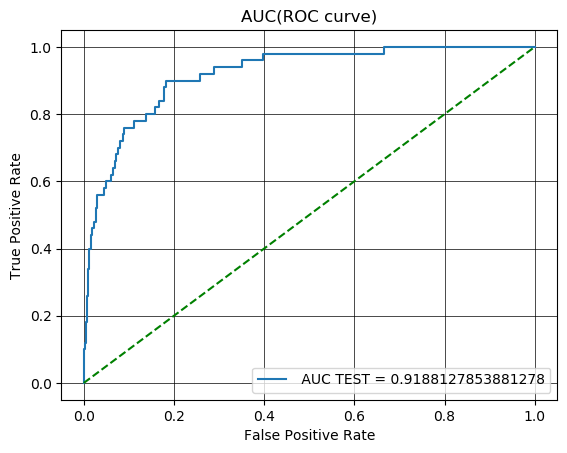

In [30]:
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_prob)
auc_value = auc(test_fpr, test_tpr)

plt.grid()
plt.plot(test_fpr, test_tpr, label=f" AUC TEST = {auc_value}")
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()
